In [1]:
from qiskit import QuantumCircuit
 
 
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc
 
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

In [2]:
from qiskit.quantum_info import SparsePauliOp
 
# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))
 
operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# If you have not previously saved your credentials, follow instructions at
# https://docs.quantum.ibm.com/guides/setup-channel#iqp
# to authenticate with your API token.
 
service = QiskitRuntimeService()
 
backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=100
)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
 
isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

In [4]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
 
# Create an Estimator object
estimator = Estimator(backend, options=options)

# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

cxcssp6ztp3000833bh0


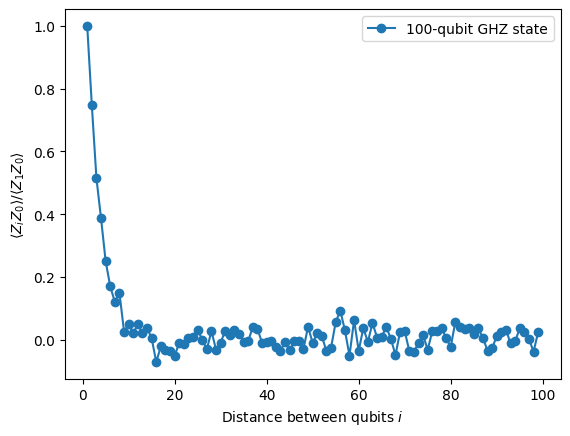

In [5]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
 
# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result = job.result()[0]
values = result.data.evs  # Expectation value at each Z operator.
values = [
    v / values[0] for v in values
]  # Normalize the expectation values to evaluate how they decay with distance.
 
# plotting graph
plt.plot(data, values, marker="o", label="100-qubit GHZ state")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()